# Molecular Dynamics Lite workflow
This notebook implements a simple molecular dynamics (MD) workflow to demonstrate [Parsl Python parallel scripting](https://parsl-project.org/) in a Jupyter notebook. This workflow first runs MD simulations in parallel on remote resources and then renders the frames of an animation visualizing the simulation according to the schematic below.

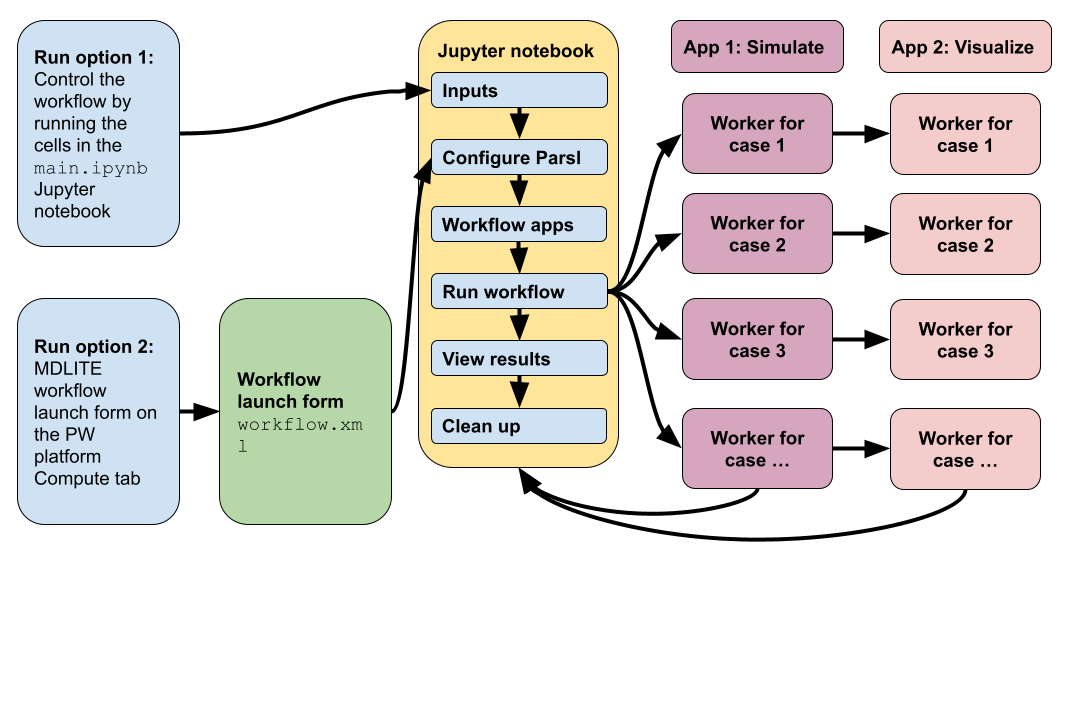

In [1]:
from IPython.display import Image
Image("images/mdlite-parameter-sweep.png")

## Step 1: Define workflow inputs
This PW workflow can be either launched from its form in the `Compute` tab or it can be run directly in this notebook.  If running directly from the notebook, the user needs to go through the extra step of defining the inputs of the workfow in the notebook.

In [2]:
import os
from os.path import exists

print('Define workflow inputs...')

# Start assuming workflow is launched from the form.
run_in_notebook=False

if (exists("./params.run")):
    print("Running from a PW form.")
    
else:
    print("Running from a notebook.")
    
    # Set flag for later
    run_in_notebook=True
    
    #TO DO: AUTOMATE THE PROCESS OF GRABING PW.CONF.
    
    # Manually set workflow inputs here (same as the
    # default values in workflow launch form)
    params="npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01:0.02:0.01|trsnaps;input;5:10:5|"
    # params="npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01|trsnaps;input;5|"
    
    print(params)
    
    # Write to params.run
    with open("params.run","w") as f:
        n_char_written = f.write(params+"\n")

Define workflow inputs...
Running from a notebook.
npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01:0.02:0.01|trsnaps;input;5:10:5|


## Step 2: Configure Parsl
The molecular dynamics software itself is a lightweight, precompiled executable written in C. The executable is distributed with this workflow in `./models/mdlite`, and along with input files, it is staged to the remote resources and does not need to be preinstalled.

The core visualization tool used here is a precompiled binary of [c-ray](https://github.com/vkoskiv/c-ray) distributed with this workflow in `./models/c-ray`. The executable is staged to remote resources and does not need to be preinstalled.

In addition to a Miniconda environment containing Parsl, the only other dependency of this workflow is ImageMagick's `convert` tool for image format conversion (`.ppm` to `.png`) and building animated `.gif` files from `.png` frames.

In [3]:
# Parsl essentials
import parsl
from parsl.app.app import python_app, bash_app
from parsl.data_provider.files import File

# PW essentials
from utils.path import Path
from parslpw import pwconfig,pwargs

# For embedding Design Explorer results in notebook
from IPython.display import display, HTML

# Checking inputs from the WORKFLOW FORM
if (not run_in_notebook):
    print(pwargs)

print("Configuring Parsl...")
parsl.load(pwconfig)
print("pwconfig loaded")

pwargs: Namespace(f='/home/ttnguyen37/.local/share/jupyter/runtime/kernel-036404b8-8b87-4802-8ec8-286cc65bd379.json')
Configuring Parsl...
pwconfig loaded


## Step 3: Define Parsl workflow apps
These apps are decorated with Parsl's `@bash_app` and as such are executed in parallel on the compute resources that are defined in the PW configuration loaded above.  Functions that are **not** decorated are not executed in parallel on remote resources. The files that need to be staged to remote resources will be marked with Parsl's `File()` (or its PW extension, `Path()`) in the workflow.

In [4]:
print("Defining Parsl workflow apps...")

#===================================
# Molecular dynamics simulation app
#===================================
@bash_app
def md_run(stdout='md.run.stdout', stderr='md.run.stderr', inputs=[], outputs=[]):
    return '''
    %s/runMD.sh "%s" metric.out trj.out
    outdir=%s
    mkdir -p $outdir
    mv trj.out $outdir/
    mv metric.out $outdir/
    ''' % (inputs[1],inputs[0],outputs[0])

#===================================
# App to render frames for animation
#===================================
# All frames for a given simulation
# are rendered together.

# This app takes a very simple 
# approach to zero padding by adding 
# integers to 1000.
@bash_app
def md_vis_3(stdout='md.vis.stdout', stderr='md.vis.stderr', inputs=[], outputs=[]):
    return '''
    indir=%s
    outdir=%s
    mkdir -p $outdir
    for (( ff=0; ff<%s; ff++ ))
    do
        frame_num_padded=$((1000+$ff))
        %s/renderframe $indir/trj.out $outdir/f_$frame_num_padded.ppm $ff
    done
    ''' % (inputs[2],outputs[0],inputs[0],inputs[1])

Defining Parsl workflow apps...


## Step 4: Workflow
This cell executes the workflow itself.

In [5]:
print("Running workflow...")

#============================================================================
# SETUP PARAMETER SWEEP
#============================================================================
# Generate a case list from params.run (the ranges to parameters to sweep)
os.system("python ./models/mexdex/prepinputs.py params.run cases.list")

# Each line in cases.list is a unique combination of the parameters to sweep.
with open("cases.list","r") as f:
    cases_list = f.readlines()

#============================================================================
# SIMULATE
#============================================================================
# For each line in cases.list, run and visualize a molecular dynamics simulation
# These empty lists will store the futures of Parsl-parallelized apps.
# Use Path for staging because multiple files in ./models/mdlite are needed
# and mutliple files in ./results/case_*/md are sent back to the platform.
md_run_fut = []
for ii, case in enumerate(cases_list):        
    # Run simulation
    md_run_fut.append(md_run(
        inputs=[case,
            Path("./models/mdlite")],
        outputs=[Path("./results/case_"+str(ii)+"/md")]))
    
# Call results for all app futures to require
# execution to wait for all simulations to complete.
for run in md_run_fut:
    run.result()

#============================================================================
# VISUALIZE
#============================================================================
md_vis_fut = []
for ii, case in enumerate(cases_list):
    # Get number of frames to render for this case
    nframe = int(case.split(',')[4])
    
    #=========================================================
    # Render all frames for each case in one app.  This approach
    # reduces the number of SSH connections (e.g. rsync instances) 
    # compared to an app that only renders one frame at a time.
    md_vis_fut.append(md_vis_3(
        inputs=[nframe,
                Path("./models/c-ray"),
                Path("./results/case_"+str(ii)+"/md")],
        outputs=[Path("./results/case_"+str(ii)+"/vis")]))

for vis in md_vis_fut:
    vis.result()
    
# Compile frames into movies locally
for ii, case in enumerate(cases_list):
    os.system("cd ./results/case_"+str(ii)+"/vis; convert -delay 10 *.ppm mdlite.gif")

# Compile movies into Design Explorer results locally
os.system("./models/mexdex/postprocess.sh mdlite_dex.csv mdlite_dex.html ./")

Running workflow...


0

## Step 5: View results
This step is only necessary when running directly in a notebook. The outputs of this workflow are stored in the `results` folder and they can be interactively visualized with the Design Explorer by clicking on `mdlite_dex.html` which uses `mdlite_dex.csv` and the data in the `results` folder. The Design Explorer visualization is automatically embedded below.

In [6]:
# Modify width, height, and screen resolution to display as wanted
from IPython.display import IFrame
def designExplorer(url,height=500):
    return IFrame(url, width=1000, height=height)


# Makre sure path 'datafile=/pw/workflows/test_workflow/mdlite_dex.csv' is correct
designExplorer('/preview/DesignExplorer/index.html?datafile=/pw/workflows/test_workflow/mdlite_dex.csv&colorby=kinetic',height=600)

## Step 6: Plots

This step shows the possible interaction with the simulation results. Plotting the time in second versus the root mean square of standard deviation and mean of all positions(x,y,z coordinate). In order to analyze the data, the plots are put side by side so see the difference between root mean square std vs. time(s) and root mean square mean vs. time(s). All cases are shown together in the same plot to see the difference between the particle's position by time. Lines are color coded and labeled for observation. Though on both plots, lines with the same case will display the same color and same name. If there are critical changes of position through time, meaning the particles are moving fast for that specific case.

There is nothing to import or set up with this step. Just simply run the cell to see how the data got retrieved and plots got created. Some lines could be comment or uncomment for better understanding how the plots generated.

*****Note: This Step is the same as the purpose on Step 5 which only runs in a jupyter notebook. Recommended to run with the default params above. If desired to change the params value make sure to limit the cases to 16 or less so the plots don’t look too crowded.**


### Pseudo Code

- Plots 2 graphs side by side: one is std vs. time, and the other is mean vs. time. 
    - Aim to show all cases on both of the graphs.

- To show all of std vs time and mean vs time 
-- Need a dataframe contains time and std of each case. Same as mean vs time 
-- To get dataframe of time and std, need to get a list of std, mean, and time for each case

- Might need to create dataframe variables for each cases here first to later be able to use it to graph all of it in the same graph.

- Loop through each case in results folder
    - Go through each time in each case
    -- Store in a time list: t_val_*, the * use to indicate the case number
        - Get root mean square of std and mean for x_pos, y_pos, and z_pos
            - Get std of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the formula:
              sqrt( std(x_pos)^2 + std(y_pos)^2 + std(z_pos)^2 )
            - Store in a rt_mean_sq_std_* list to later use it to combine with time list to create dataframe
              
            - Get mean of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the fomula:
              sqrt( mean(pos_x)^2 + mean(pos_y)^2 + mean(pos_z)^2 )
            - Store in a rt_mean_sq_mean_* list to later use it to combine with time list to create dataframe 
    - Put the time values and root mean square of std in a dataframe: combine t_val_* and rt_mean_sq_std_*. Name the dataframe as std_vs_time_*
    - Put the time values and root mean square of mean in a dataframe: combine t_val_* and rt_mean_sq_mean_*. Name the dataframe as mean_vs_time_*
    - Show the dataframe of root mean square of std vs time and root mean square of mean vs time for each case
    -- Store it in different case with different name such as case_0, case_1, case_2,...
- Plot each case on the same graph of std vs time and mean vs time, then lable cases by color code it.

In [7]:
# Import needed libraries
import pandas as pd
import numpy as np
import glob
import math 
import matplotlib.pyplot as plt

In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw

### Load data, clean data, and calculation

In [8]:
# Store all cases generated in results folder
# Make sure double check the path if the workflow folder named different
list_of_dirs = glob.glob("../test_workflow/results/case_*")
# print(list_of_dirs)

# All the list variables below are to store for purpose of plotting
cases = []
all_cases_time_val = []
all_cases_rt_mean_sq_std = []
all_cases_rt_mean_sq_mean = []

# Go through each case
for i in list_of_dirs:
    # print("\n\nShow case info...")
    # Give the correct path of trj.out file 
    path = i + "/md/trj.out"
    # print(path)
    # Get the case name for naming plot later
    case = i[i.index('case'):]
    print("Case:", case)
    # Put the case name in cases list
    cases.append(case)
    
    # print("Convert to data type...")
    data = pd.read_csv(path, sep=" ")
    print("Data shape",data.shape)
    
    # Add name to the columns
    data.columns=['time', 'var', 'x_pos', 'y_pos', 'z_pos', 'ig0', 'ig1', 'ig2', 'ig3', 'ig4', 'ig5']
    # Uncomment 2 lines below if desired to see the data format
    # print("Data with name columns")
    # print(data.head(2))
    
    # Get all time values of this case
    t_val = data['time'].unique()
    # print("Time values of this case:", t_val)
    # Put the list of time of this case into all_cases_time_val list
    all_cases_time_val.append(t_val)
    # all_cases_time_val[case_num] = t_val
    
    # If desired to check how many values of x_pos, y_pos, and z_pos for each time
    # then uncomment the block lines below
    ## Count total data of each time value
    # t_val_count = data.groupby('time')['x_pos','y_pos','z_pos'].count()
    # print("Total data of each time value in this case:")
    # print(t_val_count)
    
    # Create and initialize lists of root mean square for std and mean
    one_case_rt_mean_sq_std = []
    one_case_rt_mean_sq_mean = []
    # print("INITIALIZE:")
    # print(one_case_rt_mean_sq_std)
    # print(one_case_rt_mean_sq_mean)
    # Loop through the time values list for each time value
    for t in t_val:
        # print("\nWith time value:", t)
        # Get x_pos, y_pos, z_pos for each time value
        each_time = data.loc[data['time'] == t, 'x_pos':'z_pos']
        # print(each_time)
        
        # Use describe to see summary of 
        # x_pos, y_pos, z_pos for each time
        # Uncomment below if desired to see it
        # each_time.describe()

        # print("std of all position at selected time:")
        all_pos_std = each_time.std()
        # print(all_pos_std)
        
        # print("means of all position at selected time:")
        all_pos_mean = each_time.mean()
        # print(all_pos_mean)
        
        # Calculate root mean square of std and mean
        # formula: sqrt(std(x_pos)^2 + std(y_pos)^2 + std(z_pos)^2)
        rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
        # print("The root mean square std:", rt_mean_sq_std)
        # Put the root mean square std of all time in a list
        # Fix decimal points to 6
        one_case_rt_mean_sq_std.append(round(rt_mean_sq_std,6))

        # formula: sqrt(mean(pos_x)^2 + mean(pos_y)^2 + mean(pos_z)^2)
        rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
        # print("The root mean square mean:", rt_mean_sq_mean)
        # Put the root mean square mean of all time in a list
        # Fix decimal points to 6
        one_case_rt_mean_sq_mean.append(round(rt_mean_sq_mean,6))
        
    # After getting all root mean square for std and mean of all time
    # Put it in the list for all cases
    # print("One case root mean square std all time:", one_case_rt_mean_sq_std)
    all_cases_rt_mean_sq_std.append(one_case_rt_mean_sq_std)
    # print("One case root mean square mean all time:", one_case_rt_mean_sq_mean)
    all_cases_rt_mean_sq_mean.append(one_case_rt_mean_sq_mean)
    
# The block of lines below are for purpose of observing 
# what store in the lists created at the beginning
# Uncomment out if desired to see it
# print("List of all cases:", cases)
# print("Cases list length:", len(cases))
# print("List of all times in all cases:", all_cases_time_val)
# print("All cases time list length:", len(all_cases_time_val))
# print("List of all root mean square std of all time in all cases:",all_cases_rt_mean_sq_std)
# print("Root mean square std list length:", len(all_cases_rt_mean_sq_std))
# print("List of all root mean square mean of all time in all cases:",all_cases_rt_mean_sq_mean)
# print("Root mean square mean list length:", len(all_cases_rt_mean_sq_mean))

Case: case_0
Data shape (124, 11)
Case: case_1
Data shape (249, 11)
Case: case_3
Data shape (249, 11)
Case: case_2
Data shape (124, 11)
Case: case_5
Data shape (499, 11)
Case: case_4
Data shape (249, 11)
Case: case_6
Data shape (249, 11)
Case: case_9
Data shape (249, 11)
Case: case_8
Data shape (124, 11)
Case: case_11
Data shape (249, 11)
Case: case_10
Data shape (124, 11)
Case: case_7
Data shape (499, 11)
Case: case_12
Data shape (249, 11)
Case: case_13
Data shape (499, 11)
Case: case_15
Data shape (499, 11)
Case: case_14
Data shape (249, 11)


### Plot

Text(0.5, 1.0, 'Root mean square mean vs. time')

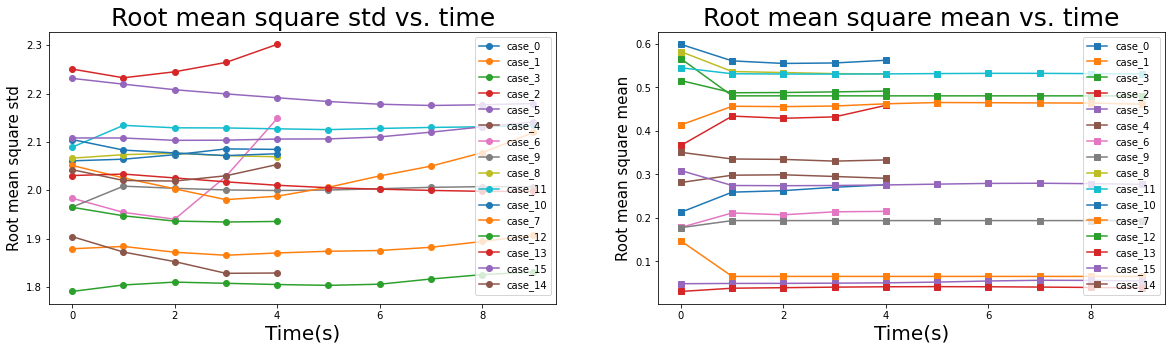

In [9]:
# Plot side by side root mean square std vs. time 
# and root mean square mean vs. time
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))

# Go through each cases to plot
# If desired to see some case not all,
# could change range(len(cases)) to range(<some number less than len(cases)>)
for c in range(len(cases)):
    # Plot root mean square std vs. time with solid line
    # and dots for each value (x,y) on the graph
    # x-axis is time, y-axis is root mean square std
    ax0.plot(all_cases_time_val[c],all_cases_rt_mean_sq_std[c],'-o')
    ax0.set_xlabel('Time(s)', fontsize=20)
    ax0.set_ylabel('Root mean square std', fontsize=15)

    # Plot root mean square mean vs. time with solid line
    # and squares for each value (x,y) on the graph
    # x-axis is time, y-axis is root mean square mean
    ax1.plot(all_cases_time_val[c],all_cases_rt_mean_sq_mean[c],'-s')
    ax1.set_xlabel('Time(s)', fontsize=20)
    ax1.set_ylabel('Root mean square mean', fontsize=15)
    
# Add legend to show name of each case
ax0.legend(cases)
ax1.legend(cases)

# Add title for each plot
ax0.set_title("Root mean square std vs. time",
              fontsize=25)
ax1.set_title("Root mean square mean vs. time",
              fontsize=25)

## Step 7: Clean up
This step is only necessary when running directly in a notebook. These intermediate and log files are removed to keep the workflow file structure clean if this workflow is pushed into the PW Market Place.  Please feel free to comment out these lines in order to inspect intermediate files as needed. The first two, `params.run` and `cases.list` are explicitly created by the workflow in Steps 1 and 4, respectively.  The other files are generated automatically for logging, keeping track of workers, or starting up workers. **Note that even the results are deleted!**

In [11]:
if (run_in_notebook):
    !rm -f params.run
    !rm -f cases.list
    !rm -rf runinfo
    !rm -rf __pycache__
    !rm -rf parsl-task.*
    !rm -rf *.pid
    !rm -rf *.started
    !rm -rf *.cancelled
    !rm -rf *.cogout
    !rm -rf lastid*
    !rm -rf launchcmd.*
    !rm -rf parsl-htex-worker.sh
    # Retain pw.conf if re-running this notebook on the 
    # same resource and there is no resource Off/On cycling.
    # (See README.md for more information.)
    !rm -rf pw.conf*
    # Delete outputs
    !rm -rf ./results
    !rm -f mdlite_dex.*